<a href="https://colab.research.google.com/github/pavanbaloju/agrivision-semantic-segmentation/blob/main/Unet_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!tar -xf drive/My\ Drive/Agriculture-Vision.tar

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import keras
from tensorflow import keras

Using TensorFlow backend.


In [ ]:
train_files = "Agriculture-Vision/train/images/nir/"
valid_files = "Agriculture-Vision/val/images/nir/"

partition =dict()
partition["train"] = sorted(os.listdir(train_files))[:2048]
partition["valid"] = sorted(os.listdir(valid_files))[:1024]

In [ ]:
class DataGenerator(keras.utils.Sequence):
  def __init__(self, ids, path, batch_size = 32, image_size=512, ):
    self.ids = ids
    self.path = path
    self.batch_size = batch_size
    self.image_size = image_size
    self.on_epoch_end()
  
  def on_epoch_end(self):
    np.random.shuffle(self.ids)
  
  def __load__(self, idname):
    rgb_path = os.path.join(self.path, "images", "rgb",idname)
    # nir_path = os.path.join(self.path, "images", "nir", idname)
    rgb_img = cv2.imread(rgb_path, 1)
   # rgb_image = np.array(r, dtype = float)
    # nir_image = np.array(cv2.imread(nir_path, -1), dtype = float)
    
    # image = np.where(nir_image + rgb_image == 0, 0, \
    #                  (nir_image - rgb_image)/(nir_image + rgb_image))
    
    labels_path = os.path.join(self.path, "labels")
    mask = np.zeros((self.image_size, self.image_size), dtype = np.bool)
    for lab_path in os.listdir(labels_path) :
      mask_path = os.path.join(labels_path, lab_path, idname[:-3]+"png")
      mask_temp = cv2.imread(mask_path, 0)
      mask = np.maximum(mask, mask_temp)
    
    image = rgb_img/255.0
    mask = mask/255.0
    return image, mask
  
  def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        #image = np.expand_dims(image, axis = -1)
        mask  = np.expand_dims(mask, axis = -1)
        return image, mask
    
  def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))


In [ ]:
ids = partition["train"]
path = "Agriculture-Vision/train"
train_gen = DataGenerator(ids, path, batch_size = 8, image_size=512,)

In [ ]:
ids2 = partition["valid"]
path2 = "Agriculture-Vision/val"
valid_gen = DataGenerator(ids2, path2, batch_size = 8, image_size=512,)

In [ ]:
pip install git+https://github.com/qubvel/segmentation_models

In [ ]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
model = sm.Unet('resnet34', encoder_weights='imagenet', classes =1, activation='sigmoid')

85524480/85521592 [==============================] - 2s 0us/step


In [ ]:
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

In [ ]:
model.fit(
   train_gen,
   #batch_size=16,
   epochs=25,
   validation_data=valid_gen,
   verbose = 1
)

Epoch 1/25
256/256 [==============================] - 148s 577ms/step - loss: 0.7375 - iou_score: 0.5164 - val_loss: 1.0710 - val_iou_score: 0.0803
Epoch 2/25
256/256 [==============================] - 137s 534ms/step - loss: 0.7162 - iou_score: 0.5294 - val_loss: 1.0852 - val_iou_score: 0.0566
Epoch 3/25
256/256 [==============================] - 137s 533ms/step - loss: 0.7050 - iou_score: 0.5384 - val_loss: 1.1282 - val_iou_score: 0.0561
Epoch 4/25
256/256 [==============================] - 135s 528ms/step - loss: 0.7075 - iou_score: 0.5374 - val_loss: 0.9681 - val_iou_score: 0.1240
Epoch 5/25
256/256 [==============================] - 135s 529ms/step - loss: 0.6939 - iou_score: 0.5461 - val_loss: 1.1041 - val_iou_score: 0.1046
Epoch 6/25
256/256 [==============================] - 135s 529ms/step - loss: 0.6939 - iou_score: 0.5470 - val_loss: 0.9913 - val_iou_score: 0.1033
Epoch 7/25
256/256 [==============================] - 135s 529ms/step - loss: 0.7092 - iou_score: 0.5349 - val_l

In [ ]:
model.save_weights("unet_best.h5")

In [ ]:
a, b = train_gen.__getitem__(10)

In [ ]:
preds = model.predict(a)

In [ ]:
preds = (preds>0.05).astype(int)

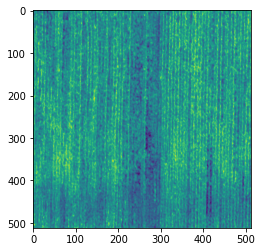

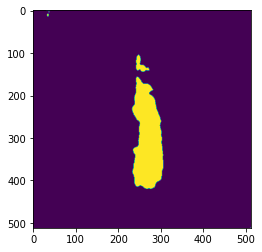

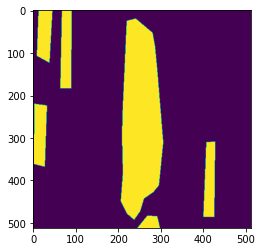

In [ ]:
index = 4
plt.imshow(a[index,:,:,0])
plt.show()
plt.imshow(preds[index,:,:,0])
plt.show()
plt.imshow(b[index,:,:,0])
plt.show()

In [ ]:
model.evaluate(valid_gen)

128/128 [==============================] - 23s 180ms/step


[0.8490139842033386, 0.06793895363807678]